In [63]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 数据加载和预处理
data_path = './^SPX.csv'
stock_data = pd.read_csv(data_path)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])  # 转换日期格式


# Data normalization and reshaping for the model
def clean_data(data, sequence_length=14, learned_percent=0.94):
    name_col = ["Close", "Open", "High", "Low", "Volume"]
    stock_data = data[name_col]
    dates = data['Date']
    close_max = stock_data['Close'].max()
    close_min = stock_data['Close'].min()
    
    df = stock_data.apply(lambda x: (x - min(x)) / (max(x) - min(x)))
    X, Y, dates_Y = [], [], []
    for i in range(df.shape[0] - sequence_length):
        X.append(np.array(df.iloc[i:(i + sequence_length), :].values, dtype=np.float32))
        Y.append(df.iloc[i + sequence_length, 0])
        dates_Y.append(dates.iloc[i + sequence_length])  # 保留对应的日期
    
    total_len = len(Y)
    train_x, train_y = X[:int(learned_percent * total_len)], Y[:int(learned_percent * total_len)]
    test_x, test_y = X[int(learned_percent * total_len):], Y[int(learned_percent * total_len):]
    test_dates = dates_Y[int(learned_percent * total_len):]  # 测试集日期
    
    return close_max, close_min, train_x, train_y, test_x, test_y, test_dates


class StockDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        x_transformed = torch.tensor(self.x[index]).float().permute(1, 0)
        y_transformed = torch.tensor(self.y[index]).float()
        return x_transformed, y_transformed

    def __len__(self):
        return len(self.x)

class BasicBlock1D(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(self.expansion*planes)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNetCnnMlp(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNetCnnMlp, self).__init__()
        self.in_planes = 64

        # ResNet特征提取层
        self.conv1 = nn.Conv1d(5, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)  # 确保无论输入如何，输出都是固定大小
        
        # MLP层
        self.fc1 = nn.Linear(512 * block.expansion, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.adaptive_pool(out)
        out = torch.flatten(out, 1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

def ResNet18():
    return ResNetCnnMlp(BasicBlock1D, [2, 2, 2, 2])

# Training function
def train(model, train_loader, optimizer, device, epoch):
    model.train()
    loss_function = nn.MSELoss()
    total_train_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = loss_function(output.squeeze(), target)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        print(f'Train Epoch: {epoch} [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.6f}')

    average_train_loss = total_train_loss / len(train_loader.dataset)
    return average_train_loss

# 确保正确使用全局变量
predictions, actuals = [], []
#打RMSE...


def test(model, close_max, close_min, test_loader, device):
    model.eval()
    loss_function = nn.MSELoss()
    predictions = []
    actuals = []
    total_test_loss = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = output.squeeze()

            actual_prices = (target * (close_max - close_min)) + close_min
            predicted_prices = (output * (close_max - close_min)) + close_min

            predictions.extend(predicted_prices.cpu().numpy())
            actuals.extend(actual_prices.cpu().numpy())

            loss = loss_function(output, target)
            total_test_loss += loss.item()

    average_test_loss = total_test_loss / len(test_loader.dataset)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    return average_test_loss, rmse, mae, r2, actuals, predictions


In [64]:
# 打RMSE版 Main execution flow
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
close_max, close_min, train_x, train_y, test_x, test_y, test_dates = clean_data(stock_data, sequence_length=14, learned_percent=0.95)
train_loader = DataLoader(StockDataset(train_x, train_y), batch_size=64, shuffle=True)
test_loader = DataLoader(StockDataset(test_x, test_y), batch_size=64, shuffle=False)
model = ResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

train_losses = []
validation_losses = []

num_epochs = 20
for epoch in range(1, num_epochs + 1):
    avg_train_loss = train(model, train_loader, optimizer, device, epoch)
    train_losses.append(avg_train_loss)

    # 在每个epoch后测试，但不立即打印结果
    avg_test_loss, rmse, mae, r2, actuals, predictions = test(model, close_max, close_min, test_loader, device)
    validation_losses.append(avg_test_loss)

    scheduler.step()


Train Epoch: 1 [0/110] Loss: 0.139837
Train Epoch: 1 [1/110] Loss: 7.003280
Train Epoch: 1 [2/110] Loss: 0.320845
Train Epoch: 1 [3/110] Loss: 0.555111
Train Epoch: 1 [4/110] Loss: 0.432832
Train Epoch: 1 [5/110] Loss: 0.147517
Train Epoch: 1 [6/110] Loss: 0.023691
Train Epoch: 1 [7/110] Loss: 0.014762
Train Epoch: 1 [8/110] Loss: 0.017764
Train Epoch: 1 [9/110] Loss: 0.013434
Train Epoch: 1 [10/110] Loss: 0.005652
Train Epoch: 1 [11/110] Loss: 0.005787
Train Epoch: 1 [12/110] Loss: 0.006280
Train Epoch: 1 [13/110] Loss: 0.011401
Train Epoch: 1 [14/110] Loss: 0.007285
Train Epoch: 1 [15/110] Loss: 0.003566
Train Epoch: 1 [16/110] Loss: 0.001749
Train Epoch: 1 [17/110] Loss: 0.002377
Train Epoch: 1 [18/110] Loss: 0.004317
Train Epoch: 1 [19/110] Loss: 0.003002
Train Epoch: 1 [20/110] Loss: 0.007555
Train Epoch: 1 [21/110] Loss: 0.003922
Train Epoch: 1 [22/110] Loss: 0.002490
Train Epoch: 1 [23/110] Loss: 0.004153
Train Epoch: 1 [24/110] Loss: 0.004519
Train Epoch: 1 [25/110] Loss: 0.002

In [65]:
# 所有训练轮次完成后打印最终评估指标
print(f'Final Avg Train Loss: {train_losses[-1]:.4f}, Final Avg Test Loss: {validation_losses[-1]:.4f}')
print(f'Final RMSE: {rmse:.4f}, Final MAE: {mae:.4f}, Final R^2: {r2:.4f}')


Final Avg Train Loss: 0.0000, Final Avg Test Loss: 0.0000
Final RMSE: 108.5135, Final MAE: 90.7828, Final R^2: 0.9259


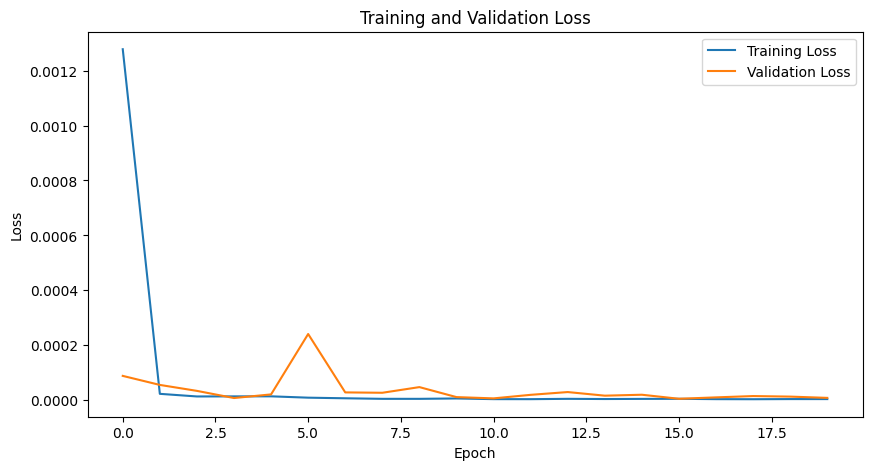

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

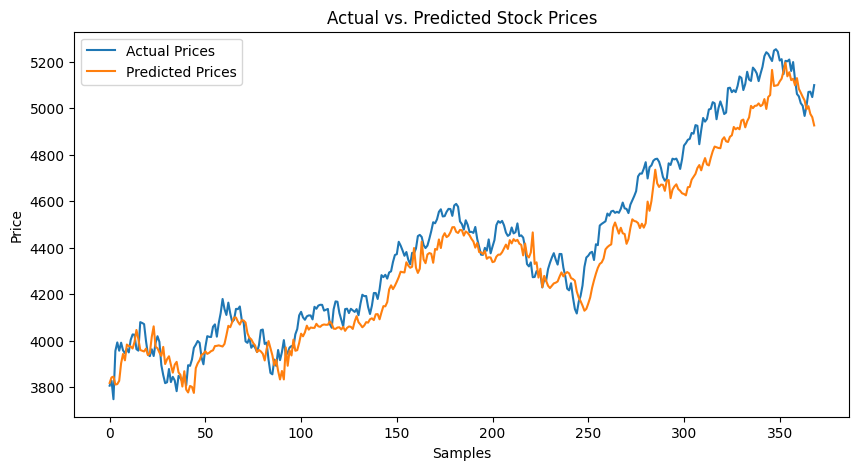

In [67]:
# Plotting predictions vs. actuals
plt.figure(figsize=(10, 5))
plt.plot(actuals, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.title("Actual vs. Predicted Stock Prices")
plt.xlabel("Samples")
plt.ylabel("Price")
plt.legend()
plt.show()

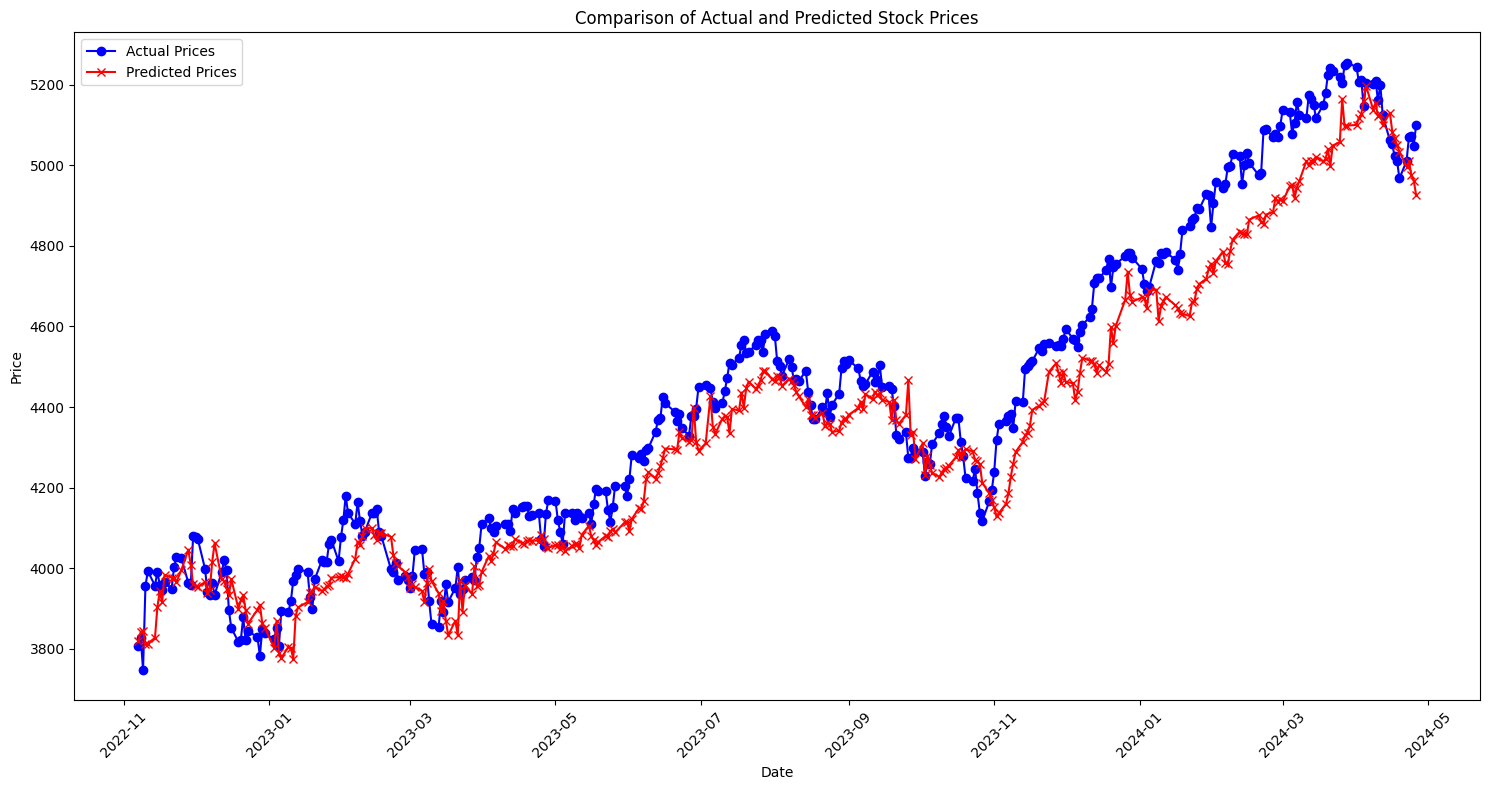

In [68]:
# actual_prices和predicted_prices已经是反标准化后的数据，并且包含相同数量的元素
# test_dates是与这些价格相对应的日期数组

plt.figure(figsize=(15, 8))
plt.plot(test_dates, actuals, label='Actual Prices', marker='o', color='blue')
plt.plot(test_dates, predictions, label='Predicted Prices', marker='x', color='red')
plt.title('Comparison of Actual and Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [69]:
# predictions和actuals数组已经由模型生成
# predictions: 预测的收盘价; actuals: 实际的收盘价
# test_dates: 测试集中每个数据点对应的日期

cash = 10000  # 初始资金
shares = 0  # 初始股票数量
trade_log = []  # 交易记录
portfolio_values = [cash]  # 初始资金作为第一个数据点的总值

for i in range(1, len(predictions)):
    if predictions[i] > actuals[i-1]:
        # 如果预测价格上涨，买入
        if cash > 0:
            shares_bought = cash / actuals[i]
            shares += shares_bought
            cash -= shares_bought * actuals[i]
            trade_log.append(('Buy', actuals[i], shares_bought, test_dates[i]))
    elif predictions[i] < actuals[i-1]:
        # 如果预测价格下跌，卖出
        if shares > 0:
            cash += shares * actuals[i]
            trade_log.append(('Sell', actuals[i], shares, test_dates[i]))
            shares = 0
    # 记录每个交易日后的总值
    total_value = cash + shares * actuals[i]
    portfolio_values.append(total_value)

# 最后一天卖出所有股票
cash += shares * actuals[-1]
trade_log.append(('Sell', actuals[-1], shares, test_dates[-1]))
shares = 0

# 记录最后一天的总值
portfolio_values.append(cash)

# 计算最终收益率
final_return = (cash - 10000) / 10000 * 100
days = (test_dates[-1] - test_dates[0]).days  # 计算总天数

# 计算年化收益率
annualized_return = (1 + final_return / 100) ** (365 / days) - 1
annualized_return_percent = annualized_return * 100  # 转换为百分比格式

print(f'Final cash: {cash}, Return: {final_return}%, Annualized Return: {annualized_return_percent:.2f}%')
print(trade_log)




Final cash: 11858.675906219332, Return: 18.586759062193323%, Annualized Return: 12.31%
[('Buy', 3828.1104, 2.612254893832502, Timestamp('2022-11-08 00:00:00')), ('Sell', 3992.9297, 2.612254893832502, Timestamp('2022-11-11 00:00:00')), ('Buy', 3965.3403, 2.630429986713876, Timestamp('2022-11-18 00:00:00')), ('Sell', 4027.2603, 2.630429986713876, Timestamp('2022-11-23 00:00:00')), ('Buy', 3963.94, 2.6724486982055047, Timestamp('2022-11-28 00:00:00')), ('Sell', 4076.5703, 2.6724486982055047, Timestamp('2022-12-01 00:00:00')), ('Buy', 3933.92, 2.769356072604368, Timestamp('2022-12-07 00:00:00')), ('Sell', 4019.65, 2.769356072604368, Timestamp('2022-12-13 00:00:00')), ('Buy', 3852.3604, 2.8896159369629566, Timestamp('2022-12-16 00:00:00')), ('Sell', 3824.1401, 2.8896159369629566, Timestamp('2023-01-03 00:00:00')), ('Buy', 3852.9697, 2.867994577808669, Timestamp('2023-01-04 00:00:00')), ('Sell', 3808.1, 2.867994577808669, Timestamp('2023-01-05 00:00:00')), ('Buy', 3898.85, 2.801238867428166,

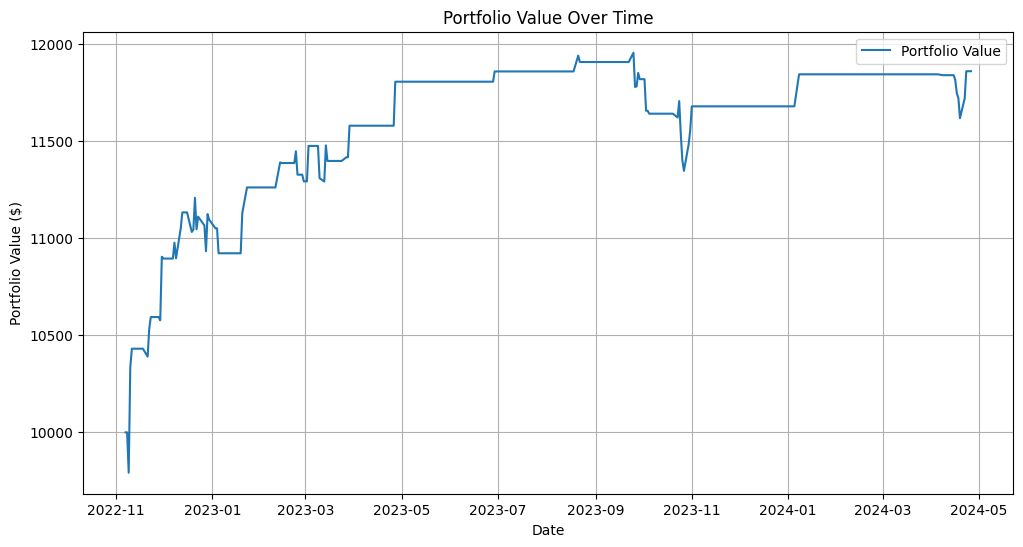

In [70]:
# 绘制收益率曲线
plt.figure(figsize=(12, 6))
plt.plot(test_dates, portfolio_values[:-1], label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
# predictions and actuals arrays have already been generated by the model
# predictions: predicted closing prices; actuals: actual closing prices
# test_dates: dates corresponding to each data point in the test set

cash = 10000  # initial capital
shares = 0  # initial number of shares
trade_log = []  # trade log
portfolio_values = [cash]  # initial capital as the first value in the portfolio

for i in range(1, len(predictions)):
    # Make decisions based on the predicted price changes
    if predictions[i] > predictions[i-1]:  # predicted price increase
        if cash > 0:  # if there is cash available, buy stocks
            shares_bought = cash / actuals[i]  # calculate number of shares to buy
            # shares_bought = 1  # calculate number of shares to buy
            shares += shares_bought  # update the total number of shares
            cash -= shares_bought * actuals[i]  # update the cash balance
            trade_log.append(('Buy', actuals[i], shares_bought, test_dates[i]))  # log the trade
    elif predictions[i] < predictions[i-1]:  # predicted price decrease
        if shares > 0:  # if there are shares available, sell them
            cash += shares * actuals[i]  # calculate the cash received from selling shares
            trade_log.append(('Sell', actuals[i], shares, test_dates[i]))  # log the trade
            shares = 0  # reset the number of shares to zero

    # Calculate the total value of the portfolio after each trade
    total_value = cash + shares * actuals[i]
    portfolio_values.append(total_value)

# Sell all remaining shares on the last day
cash += shares * actuals[-1]
trade_log.append(('Sell', actuals[-1], shares, test_dates[-1]))
shares = 0

# Record the final total value
portfolio_values.append(cash)

# Calculate final return
final_return = (cash - 10000) / 10000 * 100
days = (test_dates[-1] - test_dates[0]).days  # calculate total days

# Calculate annualized return
annualized_return = (1 + final_return / 100) ** (252 / days) - 1
annualized_return_percent = annualized_return * 100  # convert to percentage

print(f'Final cash: {cash}, Return: {final_return}%, Annualized Return: {annualized_return_percent:.2f}%')
print(trade_log)


Final cash: 10399.858280702874, Return: 3.9985828070287424%, Annualized Return: 1.86%
[('Buy', 3828.1104, 2.612254893832502, Timestamp('2022-11-08 00:00:00')), ('Sell', 3956.37, 2.612254893832502, Timestamp('2022-11-10 00:00:00')), ('Buy', 3992.9297, 2.5883368877718853, Timestamp('2022-11-11 00:00:00')), ('Sell', 3946.56, 2.5883368877718853, Timestamp('2022-11-17 00:00:00')), ('Buy', 3965.3403, 2.5760782490598273, Timestamp('2022-11-18 00:00:00')), ('Sell', 3949.94, 2.5760782490598273, Timestamp('2022-11-21 00:00:00')), ('Buy', 4026.12, 2.527335020311669, Timestamp('2022-11-25 00:00:00')), ('Sell', 3957.63, 2.527335020311669, Timestamp('2022-11-29 00:00:00')), ('Buy', 3998.8398, 2.5012896217629366, Timestamp('2022-12-05 00:00:00')), ('Sell', 3941.2603, 2.5012896217629366, Timestamp('2022-12-06 00:00:00')), ('Buy', 3933.92, 2.5059567976828037, Timestamp('2022-12-07 00:00:00')), ('Sell', 3990.56, 2.5059567976828037, Timestamp('2022-12-12 00:00:00')), ('Buy', 3852.3604, 2.5958555775651857

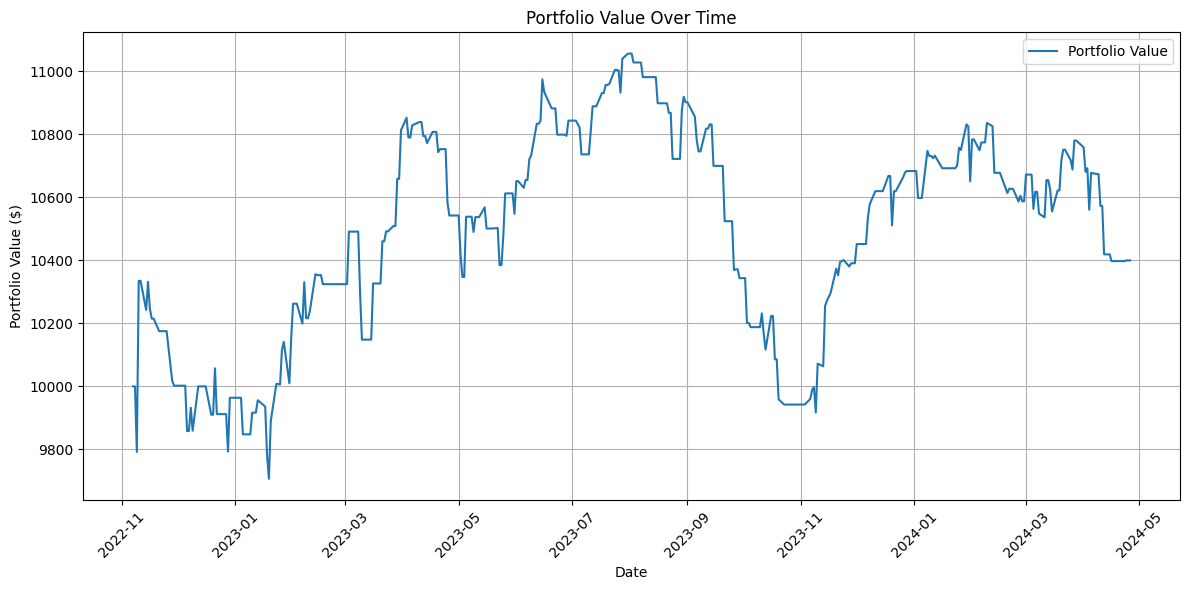

In [72]:
# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(test_dates, portfolio_values[:-1], label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()